In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so
import matplotlib.pyplot as plt

/home/cytech/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


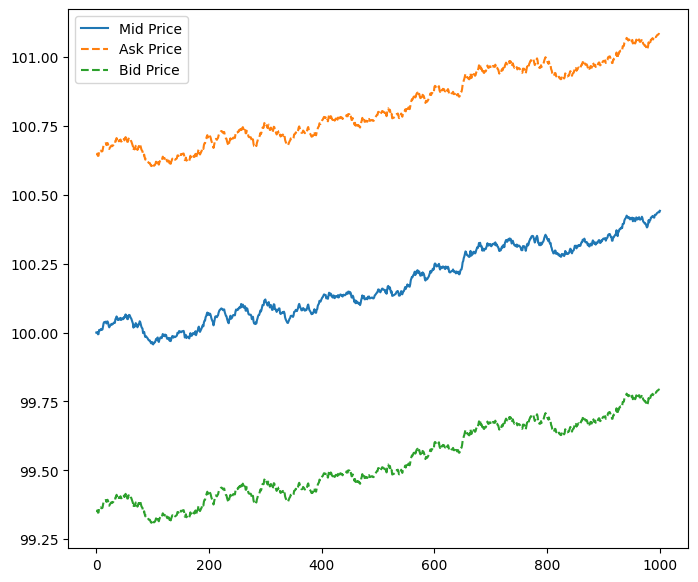

In [57]:
def price_fluctuation(S_0, N, T, sigma):
    dt = T / N
    b_increments = ss.norm.rvs(size=N, scale=np.sqrt(dt))
    b_t = np.cumsum(b_increments)
    b_t = np.insert(b_t, 0, 0)
    S = S_0 + sigma * b_t
    return S

def optimal_spread(gamma, sigma, k, T, t):
    spread = 2 / gamma * np.log(1 + gamma / k) + gamma * sigma**2 * (T - t)
    return spread / 2 

def trading_intensity(mid_price, sigma, gamma, k, T, t, q_current, lambda_ask, lambda_bid, delta, dt):
    # Reservation price calculation
    r = mid_price - q_current * gamma * sigma**2 * (T - t)

    delta_ask = delta
    delta_bid = delta

    intensity_ask = lambda_ask * np.exp(-k * delta_ask) * dt
    intensity_bid = lambda_bid * np.exp(-k * delta_bid) * dt

    N_b = ss.poisson.rvs(intensity_ask)
    N_a = ss.poisson.rvs(intensity_bid)

    cash_jump = N_b * (r + delta) - N_a * (r - delta)
    q_change = N_a - N_b

    return cash_jump, q_change

def bid_ask(mid_price, inventory, gamma, sigma, delta, T, t):
    r = mid_price - inventory * gamma * sigma**2 * (T - t)
    ask = r + delta
    bid = r - delta
    return ask, bid

def simulate_trading(S_0, N, T, sigma, gamma, k, lambda_ask, lambda_bid):
    dt = T / N
    S = price_fluctuation(S_0, N, T, sigma)
    q = np.zeros(N + 1)
    cash = np.zeros(N + 1)
    bid = np.zeros(N)
    ask = np.zeros(N)
    for t in range(N):
        current_time = t * dt
        mid_price = S[t]
        q_current = q[t]

        delta = optimal_spread(gamma, sigma, k, T, current_time)
        ask[t], bid[t] = bid_ask(mid_price, q_current, gamma, sigma, delta, T, current_time)
        cash_jump, q_change = trading_intensity(mid_price, sigma, gamma, k, T, current_time,
                                                q_current, lambda_ask, lambda_bid, delta, dt)

        q[t + 1] = q_current + q_change
        cash[t + 1] = cash[t] + cash_jump

    portfolio_value = cash + q * S
    return S, q, cash, portfolio_value, bid, ask

S_0 = 100
N = 1000
T = 1
sigma = 0.2
gamma = 0.1
k = 1.5
lambda_ask = 1
lambda_bid = 1

S, q, cash, portfolio_value, bid, ask = simulate_trading(S_0, N, T, sigma, gamma, k, lambda_ask, lambda_bid)

plt.figure(figsize=(8, 7))
plt.plot(S, label='Mid Price')
plt.plot(ask, label='Ask Price', linestyle='--')
plt.plot(bid, label='Bid Price', linestyle='--')
plt.legend()
plt.show()


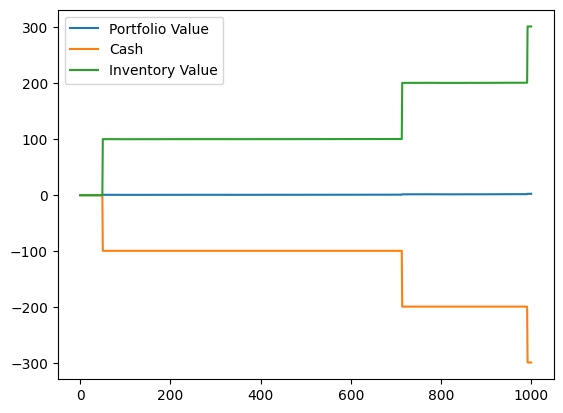

In [58]:
plt.plot(portfolio_value, label='Portfolio Value')
plt.plot(cash, label='Cash')
plt.plot(q * S, label='Inventory Value')
plt.legend()
plt.show()